In [1]:
import pandas as pd
import numpy as np
import urllib.request as urq
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor

# Detecção de novidades (outliers) da predição da qualidade de vinhos

#### Carregando uma base de dados sobre classificação de vinhos

Fonte da base de dados: http://odds.cs.stonybrook.edu/wine-dataset/

#### No exemplo abaixo, código foi obtido do repositório do github

Como se trata de um arquivo .mat, o mesmo deve ser baixado através da função urlretrive.

Caso você já tiver baixado o arquivo wine.mat, pode apagar ou comentar a próxima linha.

In [2]:
urq.urlretrieve('https://raw.githubusercontent.com/jefferson-oliva/databases/master/wine.mat', 'wine.mat')

('wine.mat', <http.client.HTTPMessage at 0x23f5358e8b0>)

In [3]:
mat = scipy.io.loadmat('wine.mat')

In [4]:
bd = pd.DataFrame(np.hstack((mat['X'], mat['y'])))

Colunas da tabela, de acordo com: https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.names

No arquivo .mat, a coluna referente à classe foi reposinada para a coluna 14 e os seus elementos foram renomeados para 1 (para representar 'inliers') e 0 (para representar 'outliers')

In [5]:
colunas = ['Alcool', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280-OD315', 'Proline', 'Classe']

In [6]:
bd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,13.29,1.97,2.68,16.8,102.0,3.00,3.23,0.31,1.66,6.00,1.07,2.84,1270.0,1.0
1,14.30,1.92,2.72,20.0,120.0,2.80,3.14,0.33,1.97,6.20,1.07,2.65,1280.0,1.0
2,13.68,1.83,2.36,17.2,104.0,2.42,2.69,0.42,1.97,3.84,1.23,2.87,990.0,1.0
3,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0,1.0
4,14.22,1.70,2.30,16.3,118.0,3.20,3.00,0.26,2.03,6.38,0.94,3.31,970.0,1.0


In [7]:
bd.columns = colunas

In [8]:
bd.shape

(129, 14)

#### Dados estatísticos da base de dados

In [9]:
bd.describe()

,Alcool,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280-OD315,Proline,Classe
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,12.726357,2.445659,2.336279,20.448837,97.449612,2.088605,1.662791,0.391395,1.467597,4.902015,0.918729,2.390775,612.093023,0.077519
std,0.743290,1.214085,0.281999,3.048978,14.812875,0.582708,0.907591,0.127725,0.572998,2.595929,0.247050,0.687786,225.483039,0.268456
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.210000,1.510000,2.200000,18.500000,87.000000,1.630000,0.800000,0.290000,1.040000,2.850000,0.720000,1.750000,465.000000,0.000000
50%,12.640000,2.060000,2.320000,20.000000,95.000000,2.000000,1.590000,0.400000,1.420000,4.000000,0.920000,2.440000,564.000000,0.000000
75%,13.290000,3.270000,2.530000,22.000000,104.000000,2.500000,2.260000,0.480000,1.770000,6.300000,1.070000,2.960000,685.000000,0.000000
max,14.340000,5.800000,3.230000,30.000000,162.000000,3.520000,5.080000,0.660000,3.580000,13.000000,1.710000,3.690000,1450.000000,1.000000


<Axes: >

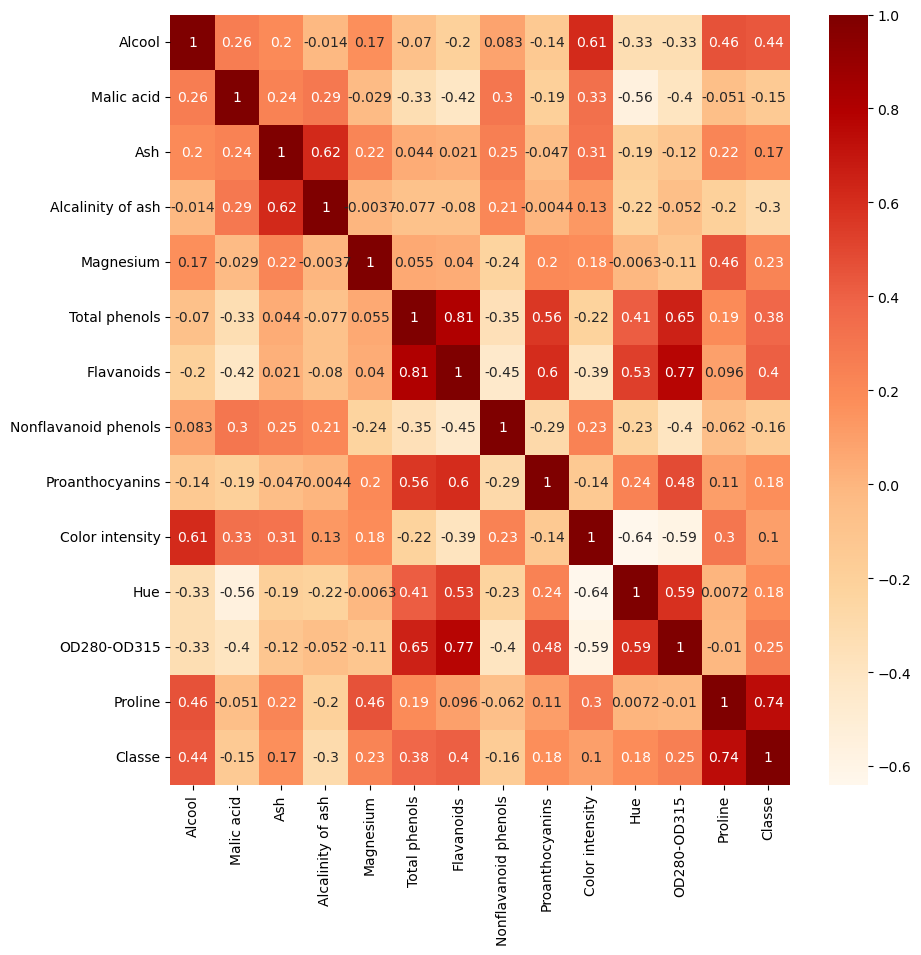

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(bd.corr(), annot=True, cmap='OrRd')

#### Removendo os atributos que possuem correlação negativa com o atributo 'Classe'

In [11]:
matriz_correlacao = bd.corr()
correlacao_classe = matriz_correlacao['Classe']
correlacao_classe

Alcool                  0.441108
Malic acid             -0.148772
Ash                     0.171020
Alcalinity of ash      -0.300547
Magnesium               0.228885
Total phenols           0.378758
Flavanoids              0.404723
Nonflavanoid phenols   -0.164950
Proanthocyanins         0.178980
Color intensity         0.102798
Hue                     0.184082
OD280-OD315             0.251005
Proline                 0.738122
Classe                  1.000000
Name: Classe, dtype: float64

In [12]:
atributos_remover = correlacao_classe[correlacao_classe < 0].index
atributos_remover

Index(['Malic acid', 'Alcalinity of ash', 'Nonflavanoid phenols'], dtype='object')

In [13]:
bd1 = bd.drop(atributos_remover, axis=1)
bd1.head()

,Alcool,Ash,Magnesium,Total phenols,Flavanoids,Proanthocyanins,Color intensity,Hue,OD280-OD315,Proline,Classe
0,13.29,2.68,102.0,3.00,3.23,1.66,6.00,1.07,2.84,1270.0,1.0
1,14.30,2.72,120.0,2.80,3.14,1.97,6.20,1.07,2.65,1280.0,1.0
2,13.68,2.36,104.0,2.42,2.69,1.97,3.84,1.23,2.87,990.0,1.0
3,14.06,2.61,121.0,2.60,2.51,1.25,5.05,1.06,3.58,1295.0,1.0
4,14.22,2.30,118.0,3.20,3.00,2.03,6.38,0.94,3.31,970.0,1.0


#### Verificação de valores únicos referentes à qualidade de vinhos

In [14]:
bd1['Classe'].unique()

array([1., 0.])

#### Plotar histogramas referentes às classes

(array([119.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  10.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

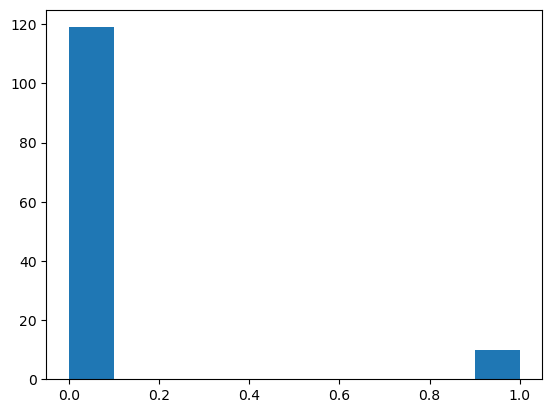

In [15]:
plt.hist(bd1['Classe'])

#### Ajustar a base de dados

Na detecção de novidades usando Python, -1 deve ser a classe negativa (outlier) e +1 deve ser positiva

y: classes das instâncias
x: instâncias

In [16]:
y = bd1['Classe'].copy()

In [17]:
for i in range(len(y)):
    if (y[i] == 1):
        y[i] = -1
    else:
        y[i] = 1

#### Remover a coluna referente à classe

In [18]:
x = bd1.drop(labels = ['Classe'], axis = 1)

#### Scatter plot para todos os pares possíveis de atributos

In [19]:
pos_out = y[y == -1].index
pos_in = y[y == 1].index

C:\Users\Marcio\AppData\Local\Temp\ipykernel_19056\3927787083.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4, 4))


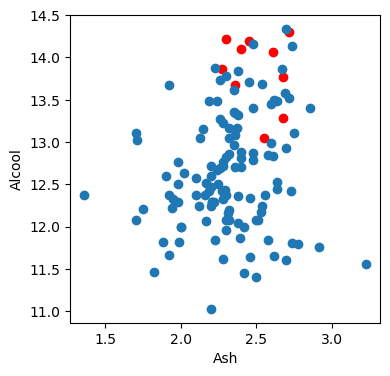

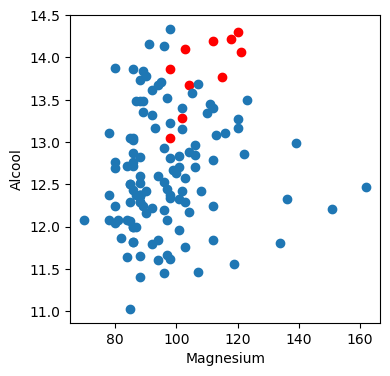

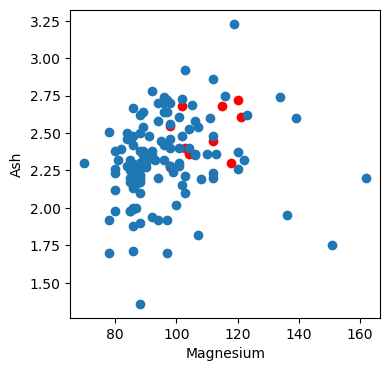

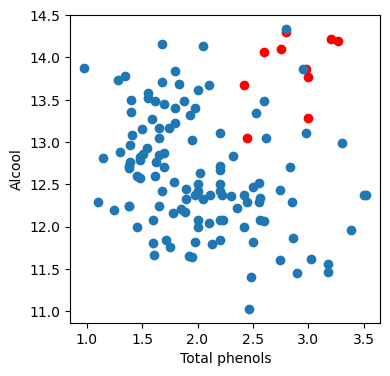

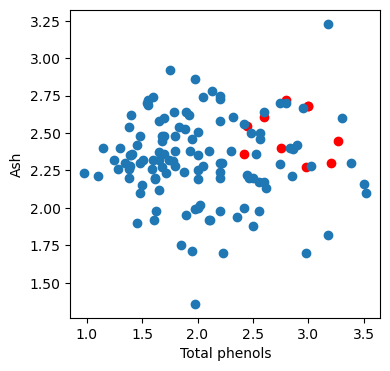

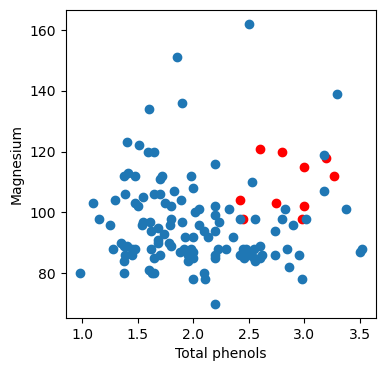

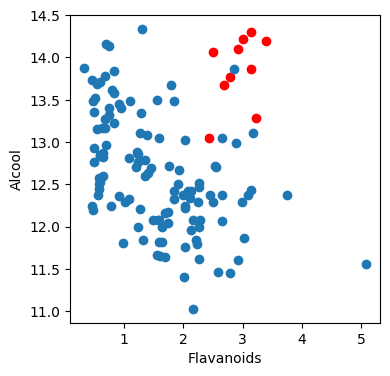

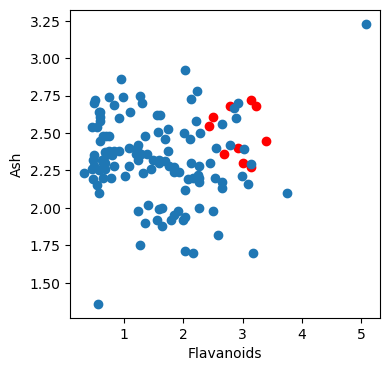

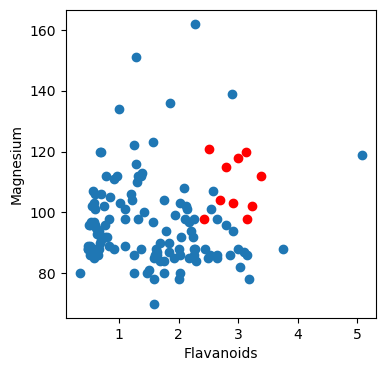

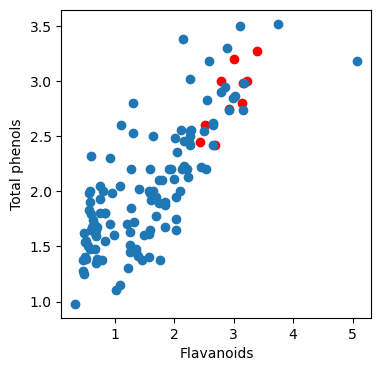

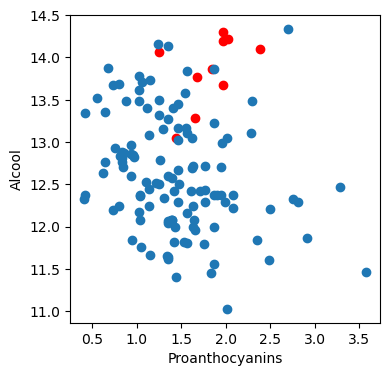

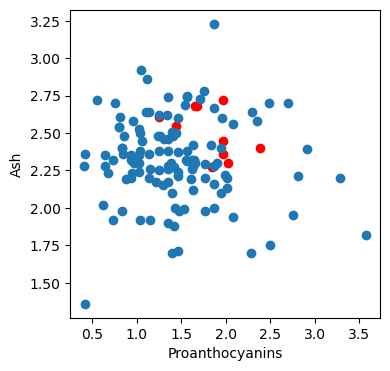

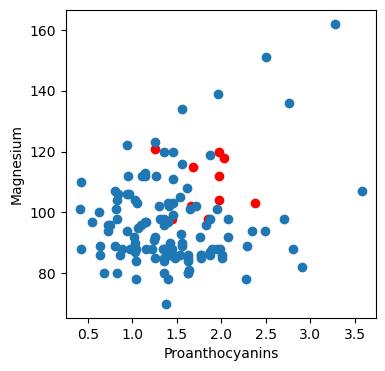

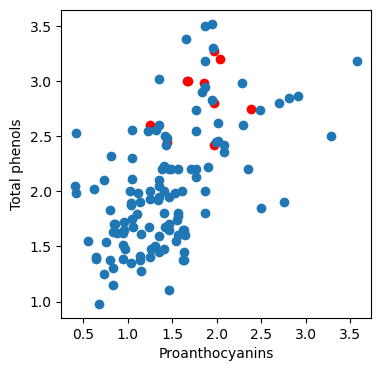

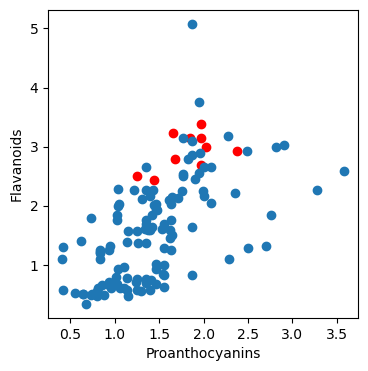

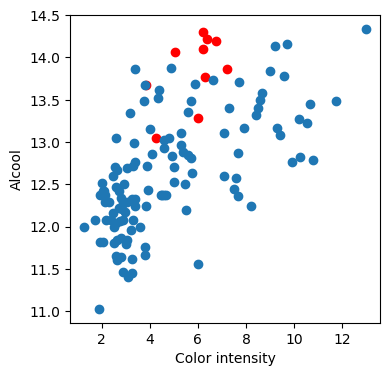

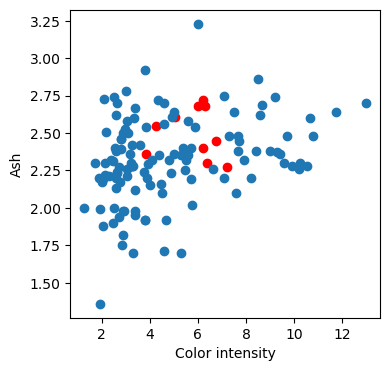

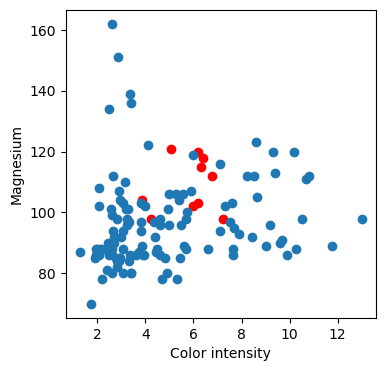

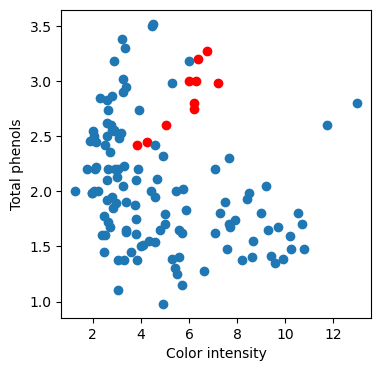

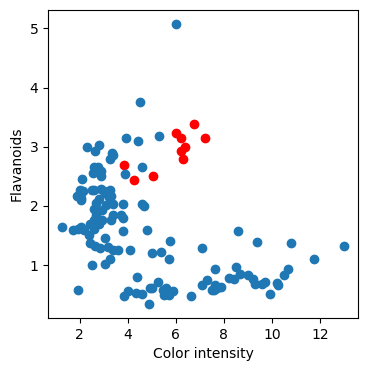

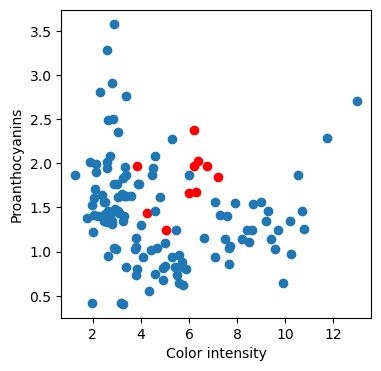

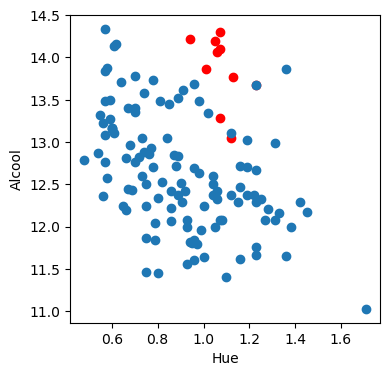

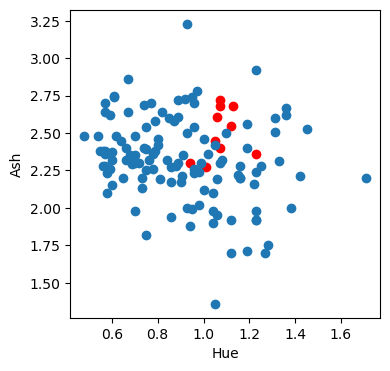

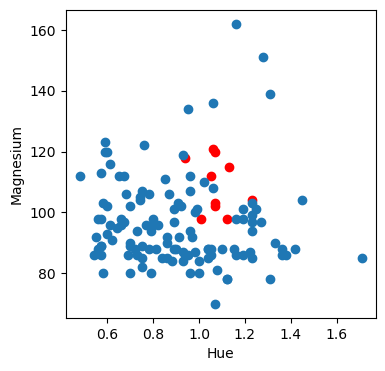

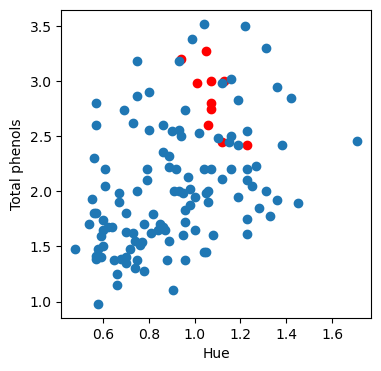

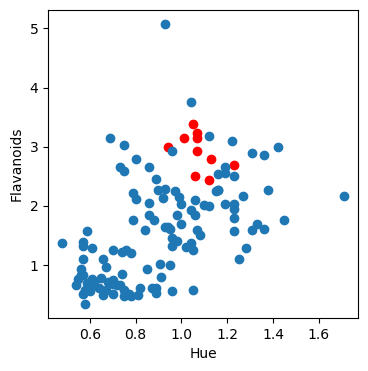

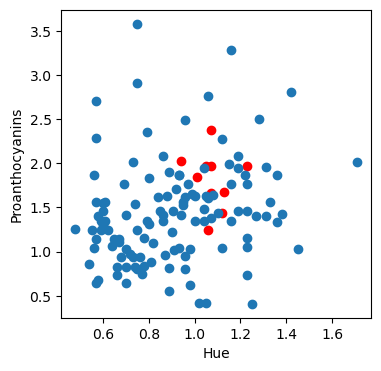

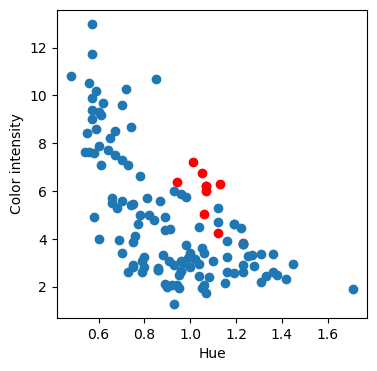

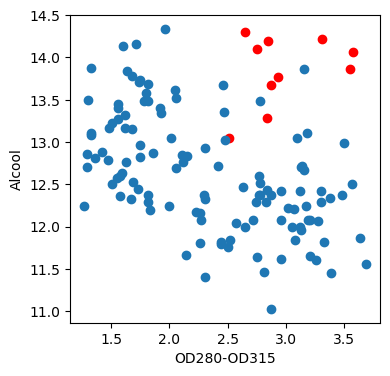

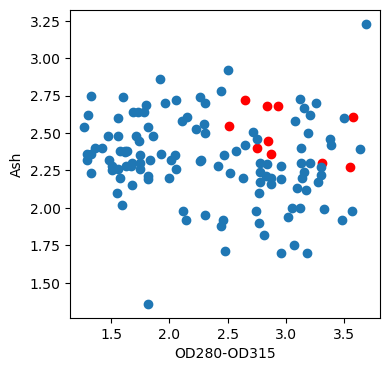

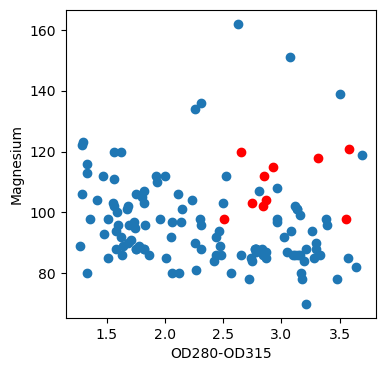

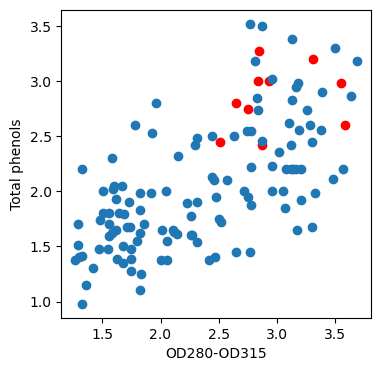

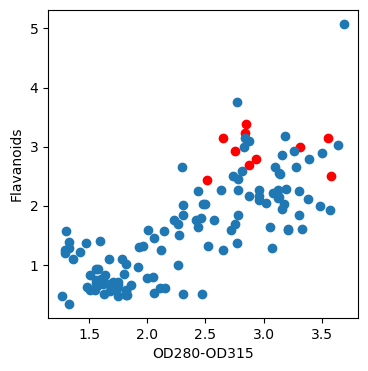

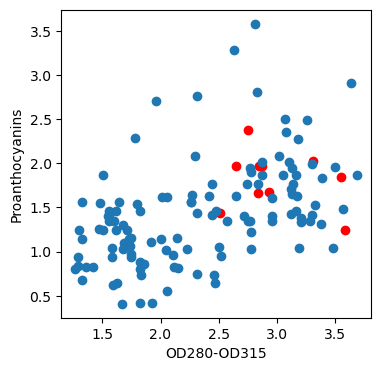

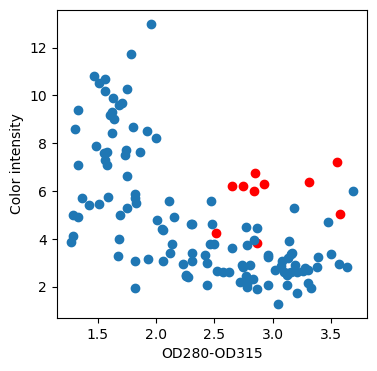

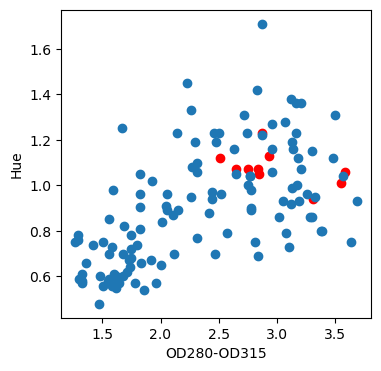

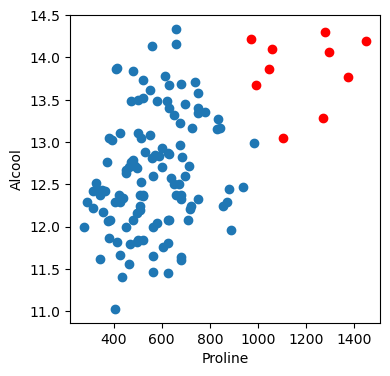

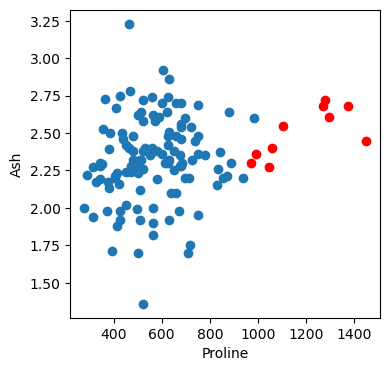

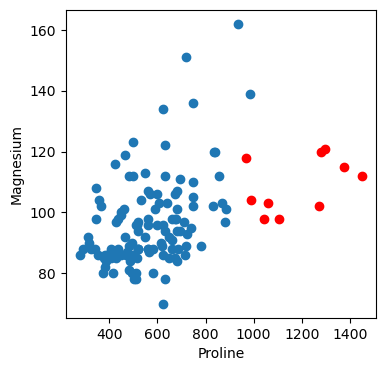

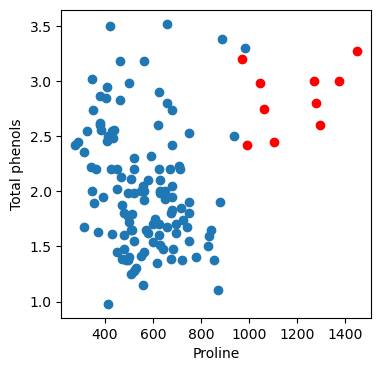

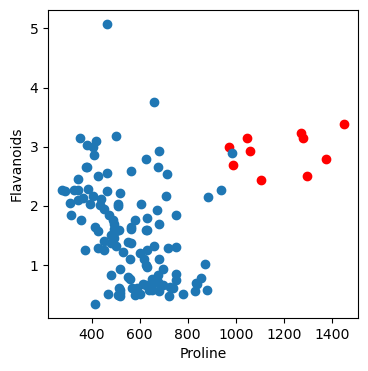

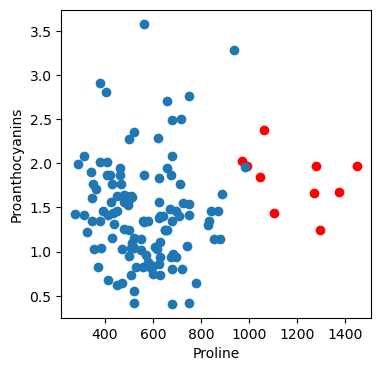

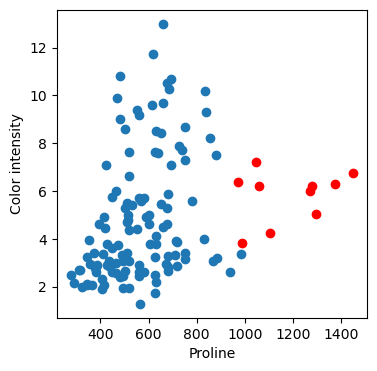

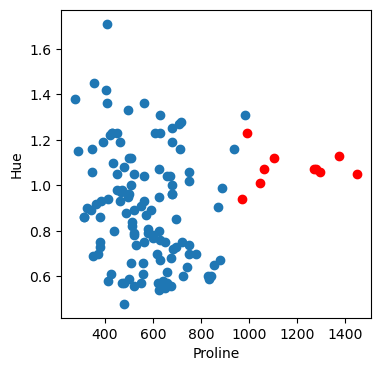

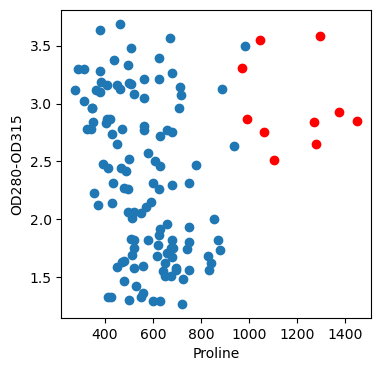

In [20]:
colunas = bd1.columns

for i in range(x.shape[1]):
    for j in range(i):
        if (i != j):
            plt.figure(figsize=(4, 4))
            plt.scatter(bd1[colunas[i]][pos_out], bd1[colunas[j]][pos_out], color='red')
            plt.scatter(bd1[colunas[i]][pos_in], bd1[colunas[j]][pos_in])
            plt.xlabel(colunas[i])
            plt.ylabel(colunas[j])

### Dividir o conjunto de dados em 70% para treino e o restante, para teste.

Para o treinamento de classificadores, iremos utilizar apenas exemplos de classe positiva (não outlier)

Todos os outliers serão utilizados para o teste do modelo

In [21]:
x_outlier = x.drop(index = pos_in)

In [22]:
y_outlier = y.drop(index = pos_in)

In [23]:
x = x.drop(index = pos_out)

In [24]:
y = y.drop(index = pos_out)

In [25]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.30, random_state=123, shuffle=True)

In [26]:
y_teste = pd.concat([y_teste, y_outlier])

In [27]:
x_teste = pd.concat([x_teste, x_outlier])

#### Fazendo com que o conjunto de treinamento também tenha outliers

In [28]:
x_treino = pd.concat([x_treino, x_outlier])
y_treino = pd.concat([y_treino, y_outlier])

### Exemplo de classificador utilizando uma abordagem "tradicional": kNN

In [29]:
kNN = KNeighborsClassifier(n_neighbors = 1)

In [30]:
kNN.fit(x_treino, y_treino)

KNeighborsClassifier(n_neighbors=1)

In [31]:
res = kNN.predict(x_teste)

#### Matriz de confusão conforme a função 'confusion_matrix'

\begin{vmatrix}
VN & FP\\ 
FN & VP
\end{vmatrix}

Onde:
* VP: verdadeiros positivos
* FN: falsos negativos
* VN: verdadeiros negativos
* FP: falsos positivos

Abaixo podemos ver que todos os outliers foram classificados incorretamente. Como você resolveria esse problema? Se utilizarmos outliers para o treinamento de classificadores, será que os resultados seriam melhores?

In [32]:
mat = confusion_matrix(y_teste, res)
mat

array([[10,  0],
       [ 0, 36]], dtype=int64)

In [33]:
vn, fp, fn, vp = mat.ravel()

#### Acurácia (Ac)

$Ac = \frac{VP + VN}{VP + FN + VN + FP}$


In [34]:
accuracy_score(y_teste, res)

1.0

In [35]:
(vp + vn) / (vp + vn + fn + fp)

1.0

#### Valor preditivo positivo (VPP ou precisão)

$VPP = \frac{VP}{VP + FP}$

No sklearn tem a função precision_score, mas a mesma está calculando sensitividade na realidade

In [36]:
vp / (vp + fp)

1.0

#### Sensitividade (Sen)

$Sen = \frac{VP}{VP + FN}$

No sklearn tem a função recall, mas a mesma está calculando especificidade na realidade

In [37]:
vp / (vp + fn)

1.0

#### Valor preditivo negativo (VPN)

$VPN = \frac{VN}{VN + FN}$

In [38]:
vn

10

In [39]:
fn

0

como fn e vn são 0, então VPN é zero

vn / (vn + fn)

#### Specificidade (Esp)

$Esp = \frac{VN}{VN + FP}$

No sklearn tem a função recall, mas a mesma está calculando especificidade na realidade

In [40]:
vn / (vn + fp)

1.0

### Detecção de novidades utilizando local outlier factor, que é baseado em kNN

In [41]:
lof = LocalOutlierFactor(novelty=True)

In [42]:
lof.fit(x_treino, y_treino)

LocalOutlierFactor(novelty=True)

In [43]:
resLof = lof.predict(x_teste)

D:\Workspace\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [44]:
mat = confusion_matrix(y_teste, resLof)
mat

array([[10,  0],
       [ 2, 34]], dtype=int64)

In [45]:
vn, fp, fn, vp = mat.ravel()

In [46]:
accuracy_score(y_teste, resLof)

0.9565217391304348

In [47]:
VPP = vp / (vp + fp)
VPP

1.0

In [48]:
Sen = vp / (vp + fn)
Sen

0.9444444444444444

In [49]:
VPN = vn / (vn + fn)
VPN

0.8333333333333334

In [50]:
Spe = vn / (vn + fp)
Spe

1.0

### Detecção de novidades utilizando one-class SVM

O parâmetro 'nu' tem a finalidade de ajustar o limite entre a generalização e o overfitting

In [51]:
oSVM = OneClassSVM(nu=0.125)

In [52]:
oSVM.fit(x_treino, y_treino)

OneClassSVM(nu=0.125)

In [53]:
resOSVM = oSVM.predict(x_teste)

In [54]:
mat = confusion_matrix(y_teste, resOSVM)
mat

array([[ 5,  5],
       [ 0, 36]], dtype=int64)

In [55]:
vn, fp, fn, vp = mat.ravel()

In [56]:
accuracy_score(y_teste, resOSVM)

0.8913043478260869

In [57]:
VPP = vp / (vp + fp)
VPP

0.8780487804878049

In [58]:
Sen = vp / (vp + fn)
Sen

1.0

In [59]:
VPN = vn / (vn + fn)
VPN

1.0

In [60]:
Spe = vn / (vn + fp)
Spe

0.5

#### Modelo utilizando o algoritmo DecisionTreeClassifier

In [61]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(x_treino, y_treino)
resClf = clf.predict(x_teste)

In [62]:
mat = confusion_matrix(y_teste, resClf)
mat

array([[10,  0],
       [ 0, 36]], dtype=int64)

In [63]:
vn, fp, fn, vp = mat.ravel()

In [64]:
accuracy_score(y_teste, resClf)

1.0

In [65]:
VPP = vp / (vp + fp)
VPP

1.0

In [66]:
Sen = vp / (vp + fn)
Sen

1.0

In [67]:
VPN = vn / (vn + fn)
VPN

1.0

In [68]:
Spe = vn / (vn + fp)
Spe

1.0